# Labeled Audio classification

- Audio 형태의 데이터를 다루는 방법에 대해서 알아보기
- Wav 파일의 형태와 원리를 이해하기
- 오디오데이터를 다른 다양한 형태로 변형시켜보기
- 차원이 다른 데이터에 사용가능한 classification 모델 직접 제작해보기

- ## audio data인 wav 파일은 1차원 시계열 data, 실제로는 여러 파형이 합쳐진 복합파

In [ ]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

- ## target label을 indexed label형태를 가진 dict에 저장 

In [2]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [3]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)


# label_data : 걍 label vector (ndarray)
label_data.shape

(50620,)

- 위 dataset은 1초 길이의 음성data 50620개를 가짐 
- sampling rate는 8000

- # data split (9:1)

In [4]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

#train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
#test_wav = test_wav.reshape([-1, sr, 1])

print(train_wav.shape)
print(test_wav.shape)

(45558, 8000)
(5062, 8000)


# transform to Spectogram

In [5]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [6]:
# 위에서 뽑았던 sample data
spec = wav2spec(train_wav[0])
print("Waveform shape : ",train_wav[0].shape)
print("Spectrogram shape : ",spec.shape)
print(train_wav.dtype)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)
float32


In [7]:
train_spec = np.ndarray(shape=(train_wav.shape[0],spec.shape[0],spec.shape[1]), dtype=np.float32)

print(train_wav.shape)
print(train_spec.shape)

(45558, 8000)
(45558, 130, 126)


In [8]:
# numpy는 loop를 가급적 배제하라고 들어서 어떻게 하라는건지는 모르겠지만 걍 일단함

for index in range(train_wav.shape[0]):
    train_spec[index] = np.abs(librosa.stft(train_wav[index], n_fft=258))

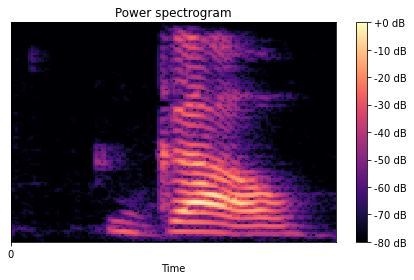

In [9]:
import matplotlib.pyplot as plt
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(train_spec[45557], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [10]:
test_spec = np.ndarray(shape=(test_wav.shape[0],spec.shape[0],spec.shape[1]), dtype=np.float32)

print(test_wav.shape)
print(test_spec.shape)

(5062, 8000)
(5062, 130, 126)


In [11]:
for index in range(test_wav.shape[0]):
    test_spec[index] = np.abs(librosa.stft(test_wav[index], n_fft=258))

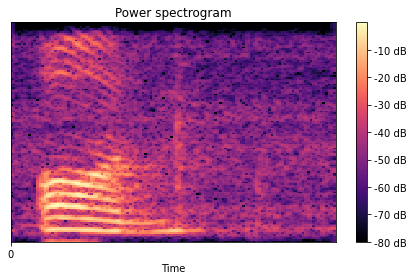

In [12]:
librosa.display.specshow(librosa.amplitude_to_db(train_spec[5061], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [13]:
batch_size = 16
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_weights'

checkpoint_dir

'/home/aiffel-dj45/aiffel/speech_recognition/models/spec_weights'

# tf.data.Dataset를 통해 모델의 효율적인 학습을 위한 입력파이프라인 구성 

- 1. input wav and label data into tensor
- 2. label one-hat encoding
- 3. data를 batch로 나눔

repeat() 함수에 count가 default이면 무한히 반복한다는데 무슨 의미인지 모르겠다 아직 

In [14]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [15]:
import tensorflow as tf

# data preprocessing
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


# Conv1D 를 이용한 model

In [16]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

- ### optimizer는 Adam, loss function은 crossentropy 사용

In [ ]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

- ### 모델 학습시 인자로 전달될 최적 weight를 저장할 callback 함수

In [18]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [19]:
history_wav = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
2839/2847 [============================>.] - ETA: 0s - loss: 1.3173 - accuracy: 0.5500
Epoch 00001: val_loss improved from inf to 0.72925, saving model to /home/aiffel-dj45/aiffel/speech_recognition/models/spec_weights
2847/2847 [==============================] - 15s 5ms/step - loss: 1.3154 - accuracy: 0.5506 - val_loss: 0.7292 - val_accuracy: 0.7611
Epoch 2/10
2840/2847 [============================>.] - ETA: 0s - loss: 0.6283 - accuracy: 0.7913
Epoch 00002: val_loss improved from 0.72925 to 0.53806, saving model to /home/aiffel-dj45/aiffel/speech_recognition/models/spec_weights
2847/2847 [==============================] - 15s 5ms/step - loss: 0.6281 - accuracy: 0.7914 - val_loss: 0.5381 - val_accuracy: 0.8252
Epoch 3/10
2846/2847 [============================>.] - ETA: 0s - loss: 0.4460 - accuracy: 0.8533
Epoch 00003: val_loss improved from 0.53806 to 0.39916, saving model to /home/aiffel-dj45/aiffel/speech_recognition/models/spec_weights
2847/2847 [=======================

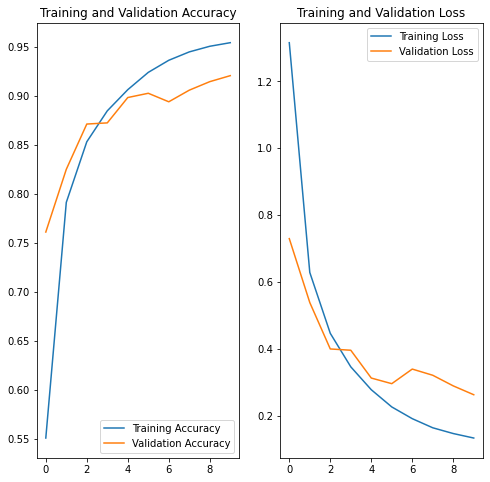

In [20]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
model_spec.load_weights(checkpoint_dir)

results = model_spec.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

317/317 [==============================] - 13s 39ms/step - loss: 0.2619 - accuracy: 0.9210
loss value: 0.262
accuracy value: 92.0980%


# Skip-Connection model

In [22]:
input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 130, 32)      36320       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 130, 32)      9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 65, 32)       0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [23]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [24]:
# the save point
checkpoint_dir2 = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec_skip_weights'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir2,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [25]:
#30분 내외 소요
history_wav_skip = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
2846/2847 [============================>.] - ETA: 0s - loss: 1.4056 - accuracy: 0.5201
Epoch 00001: val_loss improved from inf to 0.83886, saving model to /home/aiffel-dj45/aiffel/speech_recognition/models/spec_skip_weights
2847/2847 [==============================] - 17s 6ms/step - loss: 1.4053 - accuracy: 0.5202 - val_loss: 0.8389 - val_accuracy: 0.7219
Epoch 2/10
2840/2847 [============================>.] - ETA: 0s - loss: 0.6761 - accuracy: 0.7745
Epoch 00002: val_loss improved from 0.83886 to 0.47383, saving model to /home/aiffel-dj45/aiffel/speech_recognition/models/spec_skip_weights
2847/2847 [==============================] - 17s 6ms/step - loss: 0.6757 - accuracy: 0.7746 - val_loss: 0.4738 - val_accuracy: 0.8374
Epoch 3/10
2842/2847 [============================>.] - ETA: 0s - loss: 0.4574 - accuracy: 0.8491
Epoch 00003: val_loss improved from 0.47383 to 0.40076, saving model to /home/aiffel-dj45/aiffel/speech_recognition/models/spec_skip_weights
2847/2847 [========

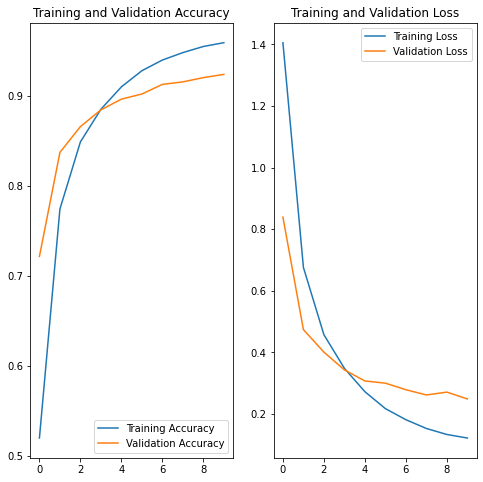

In [26]:
acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
model_spec_skip.load_weights(checkpoint_dir2)

results = model_spec_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

317/317 [==============================] - 4s 12ms/step - loss: 0.2484 - accuracy: 0.9241
loss value: 0.248
accuracy value: 92.4141%


- ### Spectogram model
  loss value: 0.248 / accuracy value: 92.4141%

- ### 1D-conv model
  loss value: 0.262 / accuracy value: 92.0980%